# モジュール・関数

In [6]:
#Delta thetaH 含むVer
#モジュールのインポート
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2])

<Figure size 1200x1000 with 0 Axes>

In [16]:
##########関数の定義################################################################################################
def E(theta,thetaH,HR,fMeff):  #飽和磁化あたりの磁気モーメントのエネルギーE(J/emu)
    Theta=np.radians(theta)
    ThetaH=np.radians(thetaH)
    E=-HR*np.cos(ThetaH-Theta)+fMeff/2*np.cos(Theta)**2
    return E

def dE(theta,thetaH,HR,gamma,fMeff):
    Theta=np.radians(theta)
    ThetaH=np.radians(thetaH)
    return -HR*np.sin(ThetaH-Theta)-fMeff/2*np.sin(2*Theta)

def dE0(theta,thetaH,gamma,fMeff,f):
    Theta=np.radians(theta)
    ThetaH=np.radians(thetaH)
    a=np.cos(ThetaH-Theta)
    b=fMeff*np.cos(Theta)**2
    c=fMeff*np.cos(2*Theta)
    d=(2*np.pi*f/gamma)**2
    k=a**2
    l=-a*(b+c)
    m=b*c-d
    HR=(-l+np.sqrt(l**2-4*k*m))/(2*k)
    return -2*HR*np.sin(ThetaH-Theta)-fMeff*np.sin(2*Theta)
    
def calculation_thetaM(thetaH,gamma,fMeff,f):
    if -90<thetaH<90:
        M=float(*optimize.fsolve((lambda theta: dE0(theta,thetaH,gamma,fMeff,f)),0))
    elif -180<thetaH<-90 or 90<thetaH<180:
        M=float(*optimize.fsolve((lambda theta: dE0(theta,180-thetaH,gamma,fMeff,f)),0))
    elif thetaH==90 or thetaH==-90:
        M=float(thetaH)
    return M
    
def quadratic_equation_p(a,b,c):
    return (-b+np.sqrt(b**2-4*a*c))/(2*a)

def HResonance(thetaH,theta,f,gamma,fMeff):
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    a=np.cos(ThetaH-Theta)
    b=fMeff*np.cos(Theta)**2
    c=fMeff*np.cos(2*Theta)
    d=(2*np.pi*f/gamma)**2
    return quadratic_equation_p(a**2,-a*(b+c),b*c-d)

def calculation_Phik(thetaH,theta,HR,fMeff):
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    if theta==0:
        Phik=0.
    else:
        arg=-Hx*np.cos(2*Theta)/(Hx+fMeff)/np.sin(Theta)**2
        if arg<0:
            Phik=0.
        elif arg>1:
            Phik=np.radians(90)
        else:
            Phik=np.arcsin(np.sqrt(arg))
    return Phik

def alpha_eff(thetaH, theta, HR, deltaHpp,gamma,fMeff,f):
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    H1=HR*np.sin(ThetaH-Theta)+fMeff*np.sin(2*Theta)
    H2=HR*np.sin(ThetaH-Theta)+2*fMeff*np.sin(2*Theta)
    zeta=(Hx+Hy)/((Hx+Hy)*np.cos(ThetaH-Theta)+(Hx*H2+Hy*H1)/Hy*np.sin(ThetaH-Theta))
    return deltaHpp/(np.abs(2*(2*np.pi*f/gamma)*zeta)/np.sqrt(3))
    

#TMSfあり
def LineWidth(thetaH,theta,HR,Phik,f,gamma,ac,fMeff,alpha,DfMeff,DThetaH,TMSf):
    X=thetaH,theta,HR,Phik,f,gamma,fMeff
    DHtot=Hdamping(X)*alpha+HfMeff(X)*DfMeff+HthetaH(X)*DThetaH+HTMS(X,ac)*TMSf
    return DHtot
"""
#TMSfなし
def LineWidth(thetaH,theta,HR,Phik,f,gamma,ac,fMeff,alpha,DfMeff,DThetaH):
    X=thetaH,theta,HR,Phik,f,gamma,fMeff
    DHtot=Hdamping(X)*alpha+HfMeff(X)*DfMeff+HthetaH(X)*DThetaH
    return DHtot
"""

def Hdamping(X):
    thetaH,theta,HR,Phik,f,gamma,fMeff=X
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    H1=HR*np.sin(ThetaH-Theta)+fMeff*np.sin(2*Theta)
    H2=HR*np.sin(ThetaH-Theta)+2*fMeff*np.sin(2*Theta)
    rwrHR=gamma*(Hx+Hy)*np.cos(ThetaH-Theta)/(2*np.sqrt(np.abs(Hx*Hy)))
    rwrth=gamma*(Hx*H2+Hy*H1)/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdHR=np.sin(ThetaH-Theta)/Hy
    dwdHR=rwrHR+rwrth*dthdHR
    return gamma*(Hx+Hy)/np.abs(dwdHR)/np.sqrt(3)

def HfMeff(X):
    thetaH,theta,HR,Phik,f,gamma,fMeff=X
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    H1=HR*np.sin(ThetaH-Theta)+fMeff*np.sin(2*Theta)
    H2=HR*np.sin(ThetaH-Theta)+2*fMeff*np.sin(2*Theta)
    rwrHR=gamma*(Hx+Hy)*np.cos(ThetaH-Theta)/(2*np.sqrt(np.abs(Hx*Hy)))
    rwrth=gamma*(Hx*H2+Hy*H1)/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdHR=np.sin(ThetaH-Theta)/Hy
    dwdHR=rwrHR+rwrth*dthdHR
    #fMeff
    rwrfMeff=gamma*(-Hy*np.cos(Theta)**2-Hx*np.cos(2*Theta))/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdfMeff=np.sin(2*Theta)/(2*Hy)
    dHRdfMeff=(rwrfMeff+rwrth*dthdfMeff)/dwdHR
    return np.abs(dHRdfMeff)/np.sqrt(3)

def HthetaH(X):
    thetaH,theta,HR,Phik,f,gamma,fMeff=X
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    H1=HR*np.sin(ThetaH-Theta)+fMeff*np.sin(2*Theta)
    H2=HR*np.sin(ThetaH-Theta)+2*fMeff*np.sin(2*Theta)
    rwrHR=gamma*(Hx+Hy)*np.cos(ThetaH-Theta)/(2*np.sqrt(np.abs(Hx*Hy)))
    rwrth=gamma*(Hx*H2+Hy*H1)/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdHR=np.sin(ThetaH-Theta)/Hy
    dwdHR=rwrHR+rwrth*dthdHR
    #thetaH
    rwrthH=-np.multiply(gamma,HR)*(Hx+Hy)*np.sin(ThetaH-Theta)/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdthH=HR*np.cos(ThetaH-Theta)/Hy
    dHRdthH=(rwrthH+rwrth*dthdthH)/dwdHR
    return np.abs(dHRdthH)/np.sqrt(3)

def HTMS(X,ac):
    thetaH,theta,HR,Phik,f,gamma,fMeff=X
    ThetaH=np.radians(thetaH)
    Theta=np.radians(theta)
    Hx=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(Theta)**2
    Hy=HR*np.cos(ThetaH-Theta)-fMeff*np.cos(2*Theta)
    H1=HR*np.sin(ThetaH-Theta)+fMeff*np.sin(2*Theta)
    H2=HR*np.sin(ThetaH-Theta)+2*fMeff*np.sin(2*Theta)
    rwrHR=gamma*(Hx+Hy)*np.cos(ThetaH-Theta)/(2*np.sqrt(np.abs(Hx*Hy)))
    rwrth=gamma*(Hx*H2+Hy*H1)/(2*np.sqrt(np.abs(Hx*Hy)))
    dthdHR=np.sin(ThetaH-Theta)/Hy
    dwdHR=rwrHR+rwrth*dthdHR
    #TMS
    NorUni2=((ac-1)*Hy**2+(ac-1)*(-Hx*np.cos(2*Theta)+Hy*np.sin(Theta)**2)**2+(Hx*np.cos(2*Theta)+Hy*np.cos(Theta)**2)**2)/(Hx+Hy)
    coeff=8*gamma**2/(2*np.sqrt(3)*np.pi**2*f)
    return coeff/np.abs(dwdHR)*np.abs(NorUni2)*Phik


# Fitting

In [24]:
##########データの代入##################################################################################################
filename='220224d-opfmr'
Filename='220224d-ni'
date='240417'

path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/OP-FMR'
f=open(f'{path}/{Filename}/{filename}.txt','rt')
x_list=[]  #theta_H(degree)
y_list=[]  #H_R(Oe)
z_list=[]  #LW(Oe

d=-0.5
n=0
for line in f :
    n=n+1
    data = line[:-1].split('\t')
    x_list.append(float(data[0])+d)
    y_list.append(float(data[1])*10)
    z_list.append(float(data[2])*10)
print('data number：',n)

##########必要な物理量################################################################################################
f=9.43*1000000000  #frequency Hz
muB=9.27401/10**28 #Bhor magnetron J/Oe
hbar=1.0456/10**34 #Dirac constant J*s
ac=1.0

##########共鳴磁場HRのフィッティング###################################################################################
Hper=max(y_list)  #H_R^perpendicurar
Hpar=min(y_list)  #H_R^parallel
gamma=4*np.pi*f/(-Hpar+np.sqrt(Hpar*(5*Hpar+4*Hper)))  #gamma
fMeff=Hper-2*np.pi*f/gamma  #4πMeff
guessHR=np.array((gamma,fMeff))
print("◯guess g-factor \t\t:",gamma*hbar/muB)
print("◯guess 4πMeff (Oe) \t:",fMeff)

thetaM=[]
Mtest=[]
for i in range(n):
    thetaM.append(calculation_thetaM(x_list[i],gamma,fMeff,f))

poptHR, pcovHR=curve_fit(lambda thetaH,gamma,fMeff :HResonance(thetaH,thetaM,f,gamma,fMeff),x_list,y_list,p0=guessHR)
perrHR=np.sqrt(np.diag(pcovHR))
print(f"●fitted g-factor \t\t: {poptHR[0]*hbar/muB:.5f}\t ± {perrHR[0]*hbar/muB:.5f}")
print(f"●fitted 4πMeff (Oe) \t: {poptHR[1]:.1f}\t ± {perrHR[1]:.2f}")
gamma=poptHR[0]
fMeff=poptHR[1]

thetaM.clear()
HR=[]
alpheff=[]
Phik=[]
for i in range(n):
    thetaM.append(calculation_thetaM(x_list[i],gamma,fMeff,f))
    HR.append(HResonance(x_list[i],thetaM[i],f,gamma,fMeff))
    Phik.append(calculation_Phik(x_list[i],thetaM[i],HR[i],fMeff))
    alpheff.append(alpha_eff(x_list[i], thetaM[i], HR[i], z_list[i],gamma,fMeff,f))
print("αeff：",min(alpheff))

m=0
set_thetaH=[]
cal_thetaM=[]
fit_HR=[]
cal_Phik=[]
for i in range(-100,100,1):
    m=m+1
    set_thetaH.append(i)
    cal_thetaM.append(calculation_thetaM(i,gamma,fMeff,f))
for i in range(m):
    fit_HR.append(HResonance(set_thetaH[i],cal_thetaM[i],f,gamma,fMeff))
    cal_Phik.append(calculation_Phik(set_thetaH[i],cal_thetaM[i],fit_HR[i],fMeff))   

##########線幅LWのフィッティング##########################################################################################
guessLW=np.array((min(alpheff),0,0,0))
boundsLW= ((0, 0, 0, 0), (100, 10000, 10000, 100000))

#TMSfあり
poptLW, pcovLW=curve_fit(lambda thetaH,alpha,DfMeff,DThetaH,TMSf:LineWidth(thetaH,thetaM,HR,Phik,f,gamma,ac,fMeff,alpha,DfMeff,DThetaH,TMSf),x_list,z_list,p0=guessLW,bounds=boundsLW)

#TMSfなし
#poptLW, pcovLW=curve_fit(lambda thetaH,alpha,DfMeff,DThetaH:LineWidth(thetaH,thetaM,HR,Phik,f,gamma,fMeff,alpha,DfMeff,DThetaH),x_list,z_list,p0=guessLW,bounds=boundsLW)

perrLW=np.sqrt(np.diag(pcovLW))
print(f"●fitted α\t\t\t: {poptLW[0]:.5f}\t ± {perrLW[0]:.5f}")
print(f"●fitted Δ4πMeff (Oe)\t: {poptLW[1]:.5f}\t ± {perrLW[1]:.5f}")
print(f"●fitted ΔθH (deg.)\t: {poptLW[2]*180/np.pi:.5f}\t ± {perrLW[2]*180/np.pi:.5f}")
print(f"●fitted TMS\t\t\t: {poptLW[3]:.2f}\t ± {perrLW[3]:.5f}")

LW=[]
Halph=[]
HDfMeff=[]
HDThetaH=[]
HTMSf=[]
for i in range(m):
    LW.append(LineWidth(set_thetaH[i],cal_thetaM[i],fit_HR[i],cal_Phik[i],f,gamma,fMeff,poptLW[0],poptLW[1],poptLW[2]))
    Halph.append(Hdamping((set_thetaH[i],cal_thetaM[i],fit_HR[i],cal_Phik[i],f,gamma,fMeff))*poptLW[0])
    HDfMeff.append(HfMeff((set_thetaH[i],cal_thetaM[i],fit_HR[i],cal_Phik[i],f,gamma,fMeff))*poptLW[1])
    HDThetaH.append(HthetaH((set_thetaH[i],cal_thetaM[i],fit_HR[i],cal_Phik[i],f,gamma,fMeff))*poptLW[2])
    HTMSf.append(HTMS((set_thetaH[i],cal_thetaM[i],fit_HR[i],cal_Phik[i],f,gamma,fMeff),ac)*poptLW[3])

##########グラフのプロット##########################################################################################
#####磁気モーメントのエネルギーvs.磁気モーメントの角度#####
ax0 = plt.subplot(gs[0])
for i in range(n):
    p=np.linspace(-100,100,200)
    plt.plot(p,E(p,x_list[i],HR[i],fMeff),color=cm.hsv(i/n))
for i in range(n):
    plt.plot(thetaM[i],E(thetaM[i],x_list[i],HR[i],fMeff),'o',color=cm.hsv(i/n),ms=10)
plt.yticks(fontsize=18)
plt.grid(True)
plt.ylabel('$E$ (J/emu)', fontsize=18)
#####外部磁場の角度vs.磁気モーメントの角度#####
ax1 = plt.subplot(gs[2], sharex = ax0)
plt.plot(thetaM,x_list,'o',ms=10)
plt.plot(cal_thetaM,set_thetaH,linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.ylabel('$θ_\mathrm{H}$ (deg.)', fontsize=18)
plt.xlabel('$θ$ (deg.)', fontsize=18)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xticks( np.arange(-90, 91, 30))
plt.yticks( np.arange(-90, 91, 30))
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)
#####共鳴磁場vs.外部磁場の角度#####
ax2 = plt.subplot(gs[1])
plt.plot(x_list,y_list,'o',ms=10)
#plt.plot(x_list,HR,linewidth=3)
plt.plot(set_thetaH,fit_HR,linewidth=3)
plt.yticks(fontsize=18)
plt.grid(True)
#plt.ylim(-100, 100)
plt.ylabel('$H_\mathrm{R}$ (Oe)', fontsize=18)
#####線幅vs.外部磁場の角度#####
ax3 = plt.subplot(gs[3], sharex = ax2)
plt.plot(x_list,z_list,'o',ms=10)
plt.plot(set_thetaH,LW,linewidth = 3.0,label='$ΔH_\mathrm{pp}^\mathrm{tot}$')
plt.plot(set_thetaH,Halph,label='$α$')
plt.plot(set_thetaH,HDfMeff,label='$Δ4πM_\mathrm{eff}$')
plt.plot(set_thetaH,HDThetaH,label='$Δθ_\mathrm{H}$')
#plt.plot(set_thetaH,HTMSf,label='$TMSf$')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.ylabel('$ΔH_\mathrm{pp}$ (Oe)', fontsize=18)
plt.xlabel('$θ_\mathrm{H}$ (deg.)', fontsize=18)
plt.xlim(-10,100)
plt.legend(fontsize=15)
plt.xticks( np.arange(0, 91, 15))
plt.setp(ax2.get_xticklabels(), visible=False)
yticks = ax3.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0,wspace=0.35)

plt.show()


Hxt=[]
Hyt=[]
H1t=[]
H2t=[]
#HTMSft=[]
dwdHR=[]
dHRdw=[]
print('θH (deg.)\tθ (deg.)\t\tφk (deg.)\tHR (Oe) ')
for i in range(n):
    ThetaH=np.radians(x_list)
    Theta=np.radians(thetaM)
    Hxt.append(HR[i]*np.cos(ThetaH[i]-Theta[i])-fMeff*np.cos(Theta[i])**2)
    Hyt.append(HR[i]*np.cos(ThetaH[i]-Theta[i])-fMeff*np.cos(2*Theta[i]))
    H1t.append(HR[i]*np.sin(ThetaH[i]-Theta[i])+fMeff*np.sin(2*Theta[i]))
    H2t.append(HR[i]*np.sin(ThetaH[i]-Theta[i])+2*fMeff*np.sin(2*Theta[i]))
    #HTMSft.append(HTMS((x_list[i],thetaM[i],HR[i],Phik[i],f,gamma,fMeff),ac)*poptLW[3])
    dwdHR.append(gamma/(2*np.sqrt(Hxt[i]*Hyt[i]))*((Hxt[i]+Hyt[i])*np.cos(ThetaH[i]-Theta[i])+(Hxt[i]*H2t[i]+Hyt[i]*H1t[i])/Hyt[i]*np.sin(ThetaH[i]-Theta[i])))
    dHRdw.append(gamma/dwdHR[i])
    print(f'{x_list[i]:.2f}\t\t{thetaM[i]:.2f}\t\t{np.degrees(Phik[i]):.2f}\t\t{HR[i]:.3f}\t\t{dHRdw[i]:.3f}')
    

data number： 37
◯guess g-factor 		: 2.2857139906276984
◯guess 4πMeff (Oe) 	: 5718.311035694627
●fitted g-factor 		: 2.41174	 ± 0.02435
●fitted 4πMeff (Oe) 	: 5824.1	 ± 39.61
αeff： 0.02341154727494353
●fitted α			: 0.03110	 ± 0.00427
●fitted Δ4πMeff (Oe)	: 35.90853	 ± 32.86177
●fitted ΔθH (deg.)	: 0.00000	 ± 0.15007
●fitted TMS			: 419.80	 ± 213.90052


TypeError: LineWidth() missing 2 required positional arguments: 'DThetaH' and 'TMSf'

# 拡大

ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

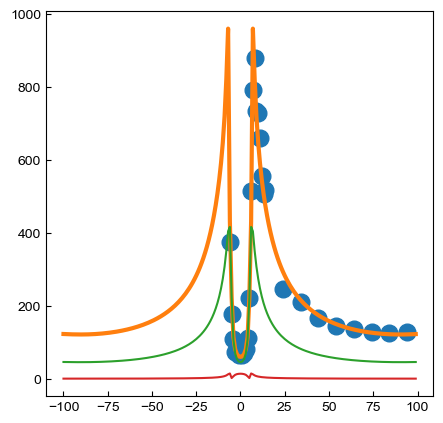

In [7]:

fig = plt.figure(figsize=(5, 5))

plt.plot(x_list,z_list,'o',ms=12)
plt.plot(set_thetaH,LW,linewidth = 3.0,label='$ΔH_\mathrm{pp}^\mathrm{tot}$')
plt.plot(set_thetaH,Halph,label='$α$')
plt.plot(set_thetaH,HDfMeff,label='$Δ4πM_\mathrm{eff}$')
plt.plot(set_thetaH,HthetaH,label='$ΔthetaH$')
plt.plot(set_thetaH,HTMSf,label='$TMSf$')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
#plt.ylabel('$ΔH_\mathrm{pp}$ (Oe)', fontsize=18)
#plt.xlabel('$θ_\mathrm{H}$ (deg.)', fontsize=18)
plt.xlim(-10,10)
plt.ylim(-10,100)
plt.xticks( np.arange(-10, 11, 2))

fig.savefig(f'figure_{filename}_large.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)